In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Importing all important library
from fastai import * # Fastai is sort of a higher level API for PyTorch
from fastai.vision import *
# from fastai.callbacks import *
import glob
import cv2
import numpy as np
from PIL import Image as im

In [3]:
# Connecting drive folder to our program. All testing, training and validation and their respective masks are stored here.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Checking if our device is CUDA enabled or not. Compute Unified Device Architecture enabled device means a program perform calculations using both the CPU and GPU. 
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device)

cuda:0


In [5]:
# Defining 4 categories for multilabel classification
colors = np.loadtxt('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/labels.txt',delimiter='\n',dtype=str);
colors

array(['Background', 'UpperBody', 'WholeBody', 'LowerBody'], dtype='<U10')

In [6]:
path_images = "/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/train"
path_valid = "/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/val"
fnames = get_image_files(path_images)

In [7]:
import posixpath
get_y_fn = lambda x: (posixpath.join('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/masks/train',f'{x.stem}{x.suffix}')) if (x.parent.stem == 'train') else (posixpath.join('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/masks/val',f'{x.stem}{x.suffix}'))
# get_y_fn=lambda x:path_lbl/f'{x.stem}_mask{x.suffix}'

In [8]:
class SegLabelListCustom(SegmentationLabelList):
        def open(self, fn): return open_mask(fn, div=False)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [9]:
"""Run this for training as during training size is 1/2 nd testing size is same as original (480,640)"""
src = (SegItemListCustom.from_folder(Path('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images'))
   .split_by_folder(train='train',valid='val')
   .label_from_func(get_y_fn, classes=colors)
   .transform(get_transforms(),tfm_y=True, size=(256,256))#tfms_y=True because transforms we r applying on trainset,will be also applied on train_masks
   .add_test_folder(test_folder='test',tfms=None,tfm_y=False)#since test_masks are empty we dont need tfms on ground truth here so tfm_y=False
   )

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]


In [10]:
data = (src
        .databunch(bs=8)
        .normalize(imagenet_stats))

In [11]:
learn = unet_learner(data,models.resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
learn.model_dir = "/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/models"
# learn.model_dir = "/content/drive/MyDrive/Academics/Ml_project_cloth_seg/dataset/categorised_new_data/images_bw/models"
learn.load("clothsegbestmodel2")

Learner(data=ImageDataBunch;

Train: LabelList (2400 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images;

Valid: LabelList (300 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images;

Test: LabelList (303 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /cont

In [ ]:
# learn.save('s1_enc_dec_unfreeze')

In [ ]:
def evaluate(file,save=True):
    test_image = open_image(file)
    img_segment = learn.predict(test_image)[0]
    test_image_data=test_image.data.permute(1,2,0)
    img_segment_data=img_segment.data*255
    img_segment_data=img_segment_data.permute(1,2,0)
    mask=img_segment.data.permute(1,2,0).numpy()
    mask=(np.squeeze(mask,axis=2))*255
    plt.imshow(mask)
    plt.show()
    # if save:
    #     cv2.imwrite('Dataset/Results/mask/'+file.split('/')[-1],mask)
    for i in range(img_segment_data.size(0)):
        for j in range(img_segment_data.size(1)):
            if img_segment_data[i,j,0] == tensor(255):
                test_image_data[i,j,:]=torch.tensor([255,255,0])

    output_numpy=test_image_data.numpy()
    plt.imshow(output_numpy)
    plt.show()
    # if save:
    #     cv2.imwrite('Dataset/Results/image_with_mask/'+file.split('/')[-1],output_numpy*255)
    
def resize_image(location):
    matrix=cv2.imread(location)
    matrix=cv2.resize(matrix,(256,256))
#     print(type(matrix))
    # cv2.imwrite(location,matrix)
    

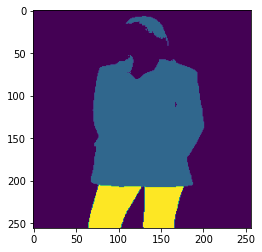

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


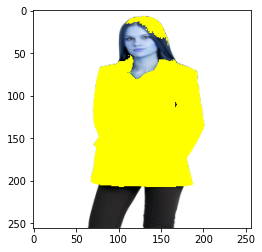

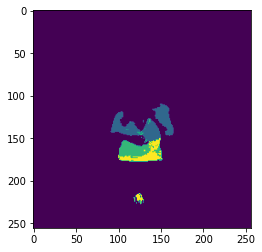

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


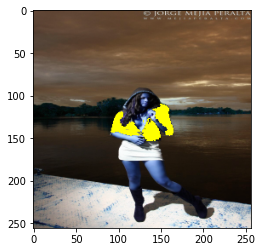

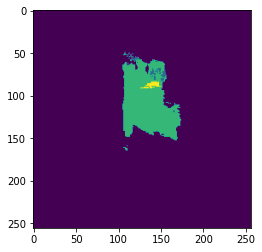

KeyboardInterrupt: ignored

In [ ]:
for datafile in glob.glob('/content/drive/MyDrive/Academics/Ml_project_cloth_seg/dataset/categorised_new_data/images1/test/*.png'):
  evaluate(datafile,True)
  

In [13]:
def evaluate1(arr):
    test_image = Image(pil2tensor(arr, dtype=np.float32).div_(255))
    # test_image = open_image(file)
    img_segment = learn.predict(test_image)[0]
    # print(img_segment)
    test_image_data=test_image.data.permute(1,2,0)
    img_segment_data=img_segment.data*255
    img_segment_data=img_segment_data.permute(1,2,0)
    mask=img_segment.data.permute(1,2,0).numpy()
    mask=(np.squeeze(mask,axis=2))*255
    return mask

In [14]:
average_accuracy = 0
num_images = 0
for i in range(2701, 3004):
  img = cv2.imread(f"/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/test/{i}.png")
  # plt.imshow(img)
  # plt.show()
  predicted_mask = evaluate1(img)/255
  # plt.imshow(predicted_mask)
  # plt.show()
  true_mask = cv2.imread(f"/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/masks/test/{i}.png")
  true_mask = cv2.resize(true_mask, (256,256), interpolation=cv2.INTER_NEAREST)
  t = np.sum(true_mask[:,:,0] == predicted_mask)/(256*256)
  print(f"{i} -> {t}")
  average_accuracy += t
  num_images += 1

2701 -> 0.9717559814453125
2702 -> 0.92230224609375
2703 -> 0.87371826171875
2704 -> 0.9737396240234375
2705 -> 0.9788360595703125
2706 -> 0.896881103515625
2707 -> 0.9577789306640625
2708 -> 0.90716552734375
2709 -> 0.980438232421875
2710 -> 0.9864654541015625
2711 -> 0.9125518798828125
2712 -> 0.9837493896484375
2713 -> 0.9220123291015625
2714 -> 0.9925994873046875
2715 -> 0.9920501708984375
2716 -> 0.9026641845703125
2717 -> 0.835845947265625
2718 -> 0.991363525390625
2719 -> 0.8949432373046875
2720 -> 0.9891357421875
2721 -> 0.9098358154296875
2722 -> 0.699249267578125
2723 -> 0.9808502197265625
2724 -> 0.993896484375
2725 -> 0.8570098876953125
2726 -> 0.883819580078125
2727 -> 0.9833526611328125
2728 -> 0.86309814453125
2729 -> 0.892974853515625
2730 -> 0.9906005859375
2731 -> 0.809417724609375
2732 -> 0.9507293701171875
2733 -> 0.9266204833984375
2734 -> 0.98516845703125
2735 -> 0.97052001953125
2736 -> 0.9264678955078125
2737 -> 0.90435791015625
2738 -> 0.8010101318359375
2739 -

In [15]:
print(f"average accuracy = {average_accuracy/num_images}")

average accuracy = 0.933441665699773


In [ ]:
predicted_mask.shape

(256, 256)

In [ ]:
np.unique(predicted_mask/255)

array([0., 1., 2., 3.])

In [ ]:
average_conf_matrix = np.zeros((4,4))
num_images = 0
total_pixels = [0,0,0,0]
for i in range(2701, 3004):
  img = cv2.imread(f"/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/images/test/{i}.png")
  predicted_mask = evaluate1(img)/255
  true_mask = cv2.imread(f"/content/drive/MyDrive/Academics/Ml_project_cloth_seg/whole_png_images/masks/test/{i}.png")[:,:,0]
  true_mask = cv2.resize(true_mask, (256,256), interpolation=cv2.INTER_NEAREST)
  conf_matrix = np.zeros((4,4))
  true = [true_mask == 0, true_mask == 1, true_mask == 2, true_mask == 3]
  predicted = [predicted_mask == 0, predicted_mask == 1, predicted_mask == 2, predicted_mask == 3]
  for j in range(4):
    total_pixels[j] += np.sum(true[j])
  for row in range(4):
    for col in range(4): 
      conf_matrix[row, col] = np.sum(true[col] & predicted[row])
  print(f"{i} -> {conf_matrix}")
  average_conf_matrix += conf_matrix
  num_images += 1

2701 -> [[6.3083e+04 1.9500e+02 0.0000e+00 1.1500e+02]
 [3.1100e+02 4.7000e+02 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.1920e+03 3.8000e+01 0.0000e+00 1.3200e+02]]
2703 -> [[5.6393e+04 1.4000e+01 1.8000e+01 0.0000e+00]
 [8.8600e+02 8.6700e+02 2.5000e+03 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [4.7800e+02 0.0000e+00 4.3800e+03 0.0000e+00]]
2704 -> [[48547.   308.     0.     0.]
 [  965. 15268.   448.     0.]
 [    0.     0.     0.     0.]
 [    0.     0.     0.     0.]]
2705 -> [[5.4689e+04 8.5000e+01 4.3000e+01 0.0000e+00]
 [5.4000e+01 2.3720e+03 1.5800e+02 0.0000e+00]
 [1.5100e+02 3.1200e+02 7.0880e+03 0.0000e+00]
 [5.7200e+02 1.0000e+00 1.1000e+01 0.0000e+00]]
2706 -> [[4.5953e+04 1.4000e+01 2.7500e+02 0.0000e+00]
 [4.4330e+03 9.8000e+01 2.1400e+02 0.0000e+00]
 [1.4330e+03 4.2000e+01 1.2727e+04 0.0000e+00]
 [2.8700e+02 0.0000e+00 6.0000e+01 0.0000e+00]]
2707 -> [[44907.   208.     0.     0.]
 [  130. 17862.     0.     0.]
 [    0. 

In [ ]:
total_pixels

[15790422, 2191850, 1156288, 718848]

In [ ]:
ans = np.zeros((4,4))
for row in range(4):
  for col in range(4):
    ans[row, col] = average_conf_matrix[row, col]/total_pixels[col]
print(f"average conf matrix - {ans}")

average conf matrix - [[0.968917 0.077131 0.047308 0.121269]
 [0.014974 0.867287 0.161402 0.03617 ]
 [0.003301 0.045541 0.717656 0.139564]
 [0.012809 0.010042 0.073634 0.702997]]
